## GridSearchCV로 모델의 성능 개선하기
* IBM sample datasets
https://www.kaggle.com/blastchar/telco-customer-churn

* Demographic info: 
    * Gender, SeniorCitizen, Partner, Dependents
* Services subscribed: 
    * PhoneService, MultipleLine, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
* Customer account info:
    * CustomerID, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Tenure

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

## 데이터 로드하기
* 전처리된 모델을 로드하기

In [3]:
df = pd.read_csv("data/telco_feature.csv")
df.shape

(7043, 51)

In [4]:
# customerID 를 인덱스로 설정하기
df = df.set_index("customerID")

In [5]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,totalcharges_group_0-2k,totalcharges_group_2k-4k,totalcharges_group_4k-6k,...,OnlineSecurity_No internet service,OnlineSecurity_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,monthlycharges_group_0-30,monthlycharges_group_30-70,monthlycharges_group_70-99,monthlycharges_group_99plus
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,False,0,True,False,False,True,False,1,0,0,...,0,0,0,0,1,0,1,0,0,0
5575-GNVDE,True,0,False,False,True,False,False,1,0,0,...,0,1,0,0,0,1,0,1,0,0
3668-QPYBK,True,0,False,False,True,True,True,1,0,0,...,0,1,0,0,0,1,0,1,0,0
7795-CFOCW,True,0,False,False,False,False,False,1,0,0,...,0,1,1,0,0,0,0,1,0,0
9237-HQITU,False,0,False,False,True,True,True,1,0,0,...,0,0,0,0,1,0,0,0,1,0


## 전처리

In [6]:
# 결측치를 채워주는 방법도 있지만 일단 제거하도록 합니다.
df = df.dropna()

In [7]:
df["Churn"].value_counts()

False    5174
True     1869
Name: Churn, dtype: int64

## 학습, 예측 데이터셋 나누기
### 학습, 예측에 사용할 컬럼

In [8]:
# 피처로 사용할 컬럼 지정하기
feature_names = df.columns.tolist()
feature_names.remove("Churn")
feature_names

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'totalcharges_group_0-2k',
 'totalcharges_group_2k-4k',
 'totalcharges_group_4k-6k',
 'totalcharges_group_6kplus',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'tenure_group_0-20',
 'tenure_group_20-40',
 'tenure_group_40-60',
 'tenure_group_60plus',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'O

### 정답값이자 예측해야 될 값

In [9]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
label_name = "Churn"
label_name

'Churn'

### 문제(feature)와 답안(label)을 나누기

* X, y를 만들어 줍니다.
* X는 feature, 독립변수, 예) 시험의 문제
* y는 label, 종속변수, 예) 시험의 정답

In [10]:
# X, y를 만들어 줍니다.
X = df.drop(label_name, axis=1)
y = df[label_name]

### 학습, 예측 데이터셋 만들기
* X_train : 학습 세트 만들기, 행렬, 판다스의 데이터프레임, 2차원 리스트(배열) 구조,  예) 시험의 기출문제
* y_train : 정답 값을 만들기, 벡터, 판다스의 시리즈, 1차원 리스트(배열) 구조, 예) 기출문제의 정답
* X_test : 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
* y_test : 예측의 정답값 예) 실전 시험 문제의 정답

In [11]:
# train_test_split 으로 데이터셋 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 49), (1409, 49), (5634,), (1409,))

In [13]:
X_train.head(3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,totalcharges_group_0-2k,totalcharges_group_2k-4k,totalcharges_group_4k-6k,totalcharges_group_6kplus,...,OnlineSecurity_No internet service,OnlineSecurity_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,monthlycharges_group_0-30,monthlycharges_group_30-70,monthlycharges_group_70-99,monthlycharges_group_99plus
customerID,,,,,,,,,,,,,,,,,,,,,
4223-BKEOR,False,0,False,True,True,False,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
6035-RIIOM,False,0,False,False,True,True,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3797-VTIDR,True,0,True,False,False,True,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [14]:
X_test.head(3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,totalcharges_group_0-2k,totalcharges_group_2k-4k,totalcharges_group_4k-6k,totalcharges_group_6kplus,...,OnlineSecurity_No internet service,OnlineSecurity_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,monthlycharges_group_0-30,monthlycharges_group_30-70,monthlycharges_group_70-99,monthlycharges_group_99plus
customerID,,,,,,,,,,,,,,,,,,,,,
1024-GUALD,False,0,True,False,False,True,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
0484-JPBRU,True,0,False,False,True,True,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3620-EHIMZ,False,0,True,True,True,False,1,0,0,0,...,1,0,0,0,0,1,1,0,0,0


In [15]:
y_train.head(2)

customerID
4223-BKEOR    False
6035-RIIOM    False
Name: Churn, dtype: bool

## 머신러닝 모델로 예측하기

In [16]:
# 트리모델 로드하기
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5, max_features=0.8)
model.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')>

In [17]:
max_depth_list = np.arange(3, 15)
max_depth_list

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [18]:
max_features_list = np.arange(0.3, 1.1, step=0.1)
max_features_list

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [19]:
from sklearn.model_selection import cross_val_predict

In [20]:
result_all = [] 
for max_depth in max_depth_list:
    for max_features in max_features_list:
        result = [] 
        model = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
        y_pred = cross_val_predict(model, X_train, y_train, cv=5, verbose=0)
        score = (y_train == y_pred).mean()
        
        result.append(model.__class__.__name__)
        result.append(model.get_params)
        result.append(max_depth)
        result.append(max_features)
        result.append(score)
        result_all.append(result)

In [21]:
df_result = pd.DataFrame(result_all, 
                         columns=["estimator", "params", "max_depth", "max_features", "score"])
df_result = df_result.sort_values("score", ascending=False)
df_result.head(10)

,estimator,params,max_depth,max_features,score
27,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,6,0.6,0.788072
14,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,4,0.9,0.785942
13,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,4,0.8,0.785765
15,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,4,1.0,0.785765
34,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,7,0.5,0.785588
30,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,6,0.9,0.785410
19,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,5,0.6,0.785055
10,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,4,0.5,0.784168
12,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,4,0.7,0.784168
2,DecisionTreeClassifier,<bound method BaseEstimator.get_params of Deci...,3,0.5,0.783813


In [32]:
param_grid = {"max_depth" : max_depth_list, "max_features" : max_features_list}

In [34]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(model, param_grid, cv=5, ve)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=6,
                                              max_features=0.9,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12,

In [41]:
rank = pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score")
rank.iloc[0]["params"]

{'max_depth': 6, 'max_features': 0.6000000000000001}

In [42]:
clf.best_params_

{'max_depth': 6, 'max_features': 0.6000000000000001}

In [43]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=0.6000000000000001,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

## 학습하기

In [45]:
# model = DecisionTreeClassifier(max_depth=6, max_features=0.9, random_state=42)
model = clf.best_estimator_
model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=0.6000000000000001,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [46]:
# 학습하기
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=0.6000000000000001,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [47]:
# 예측하기
y_predict = model.predict(X_test)
y_predict

array([ True, False, False, ..., False, False, False])

## 모델 평가하기

In [48]:
# 피처의 중요도를 추출하기

importances = pd.DataFrame({"importances" : model.feature_importances_, 
              "feature_names" :feature_names})
importances = importances.sort_values("importances", ascending=False)

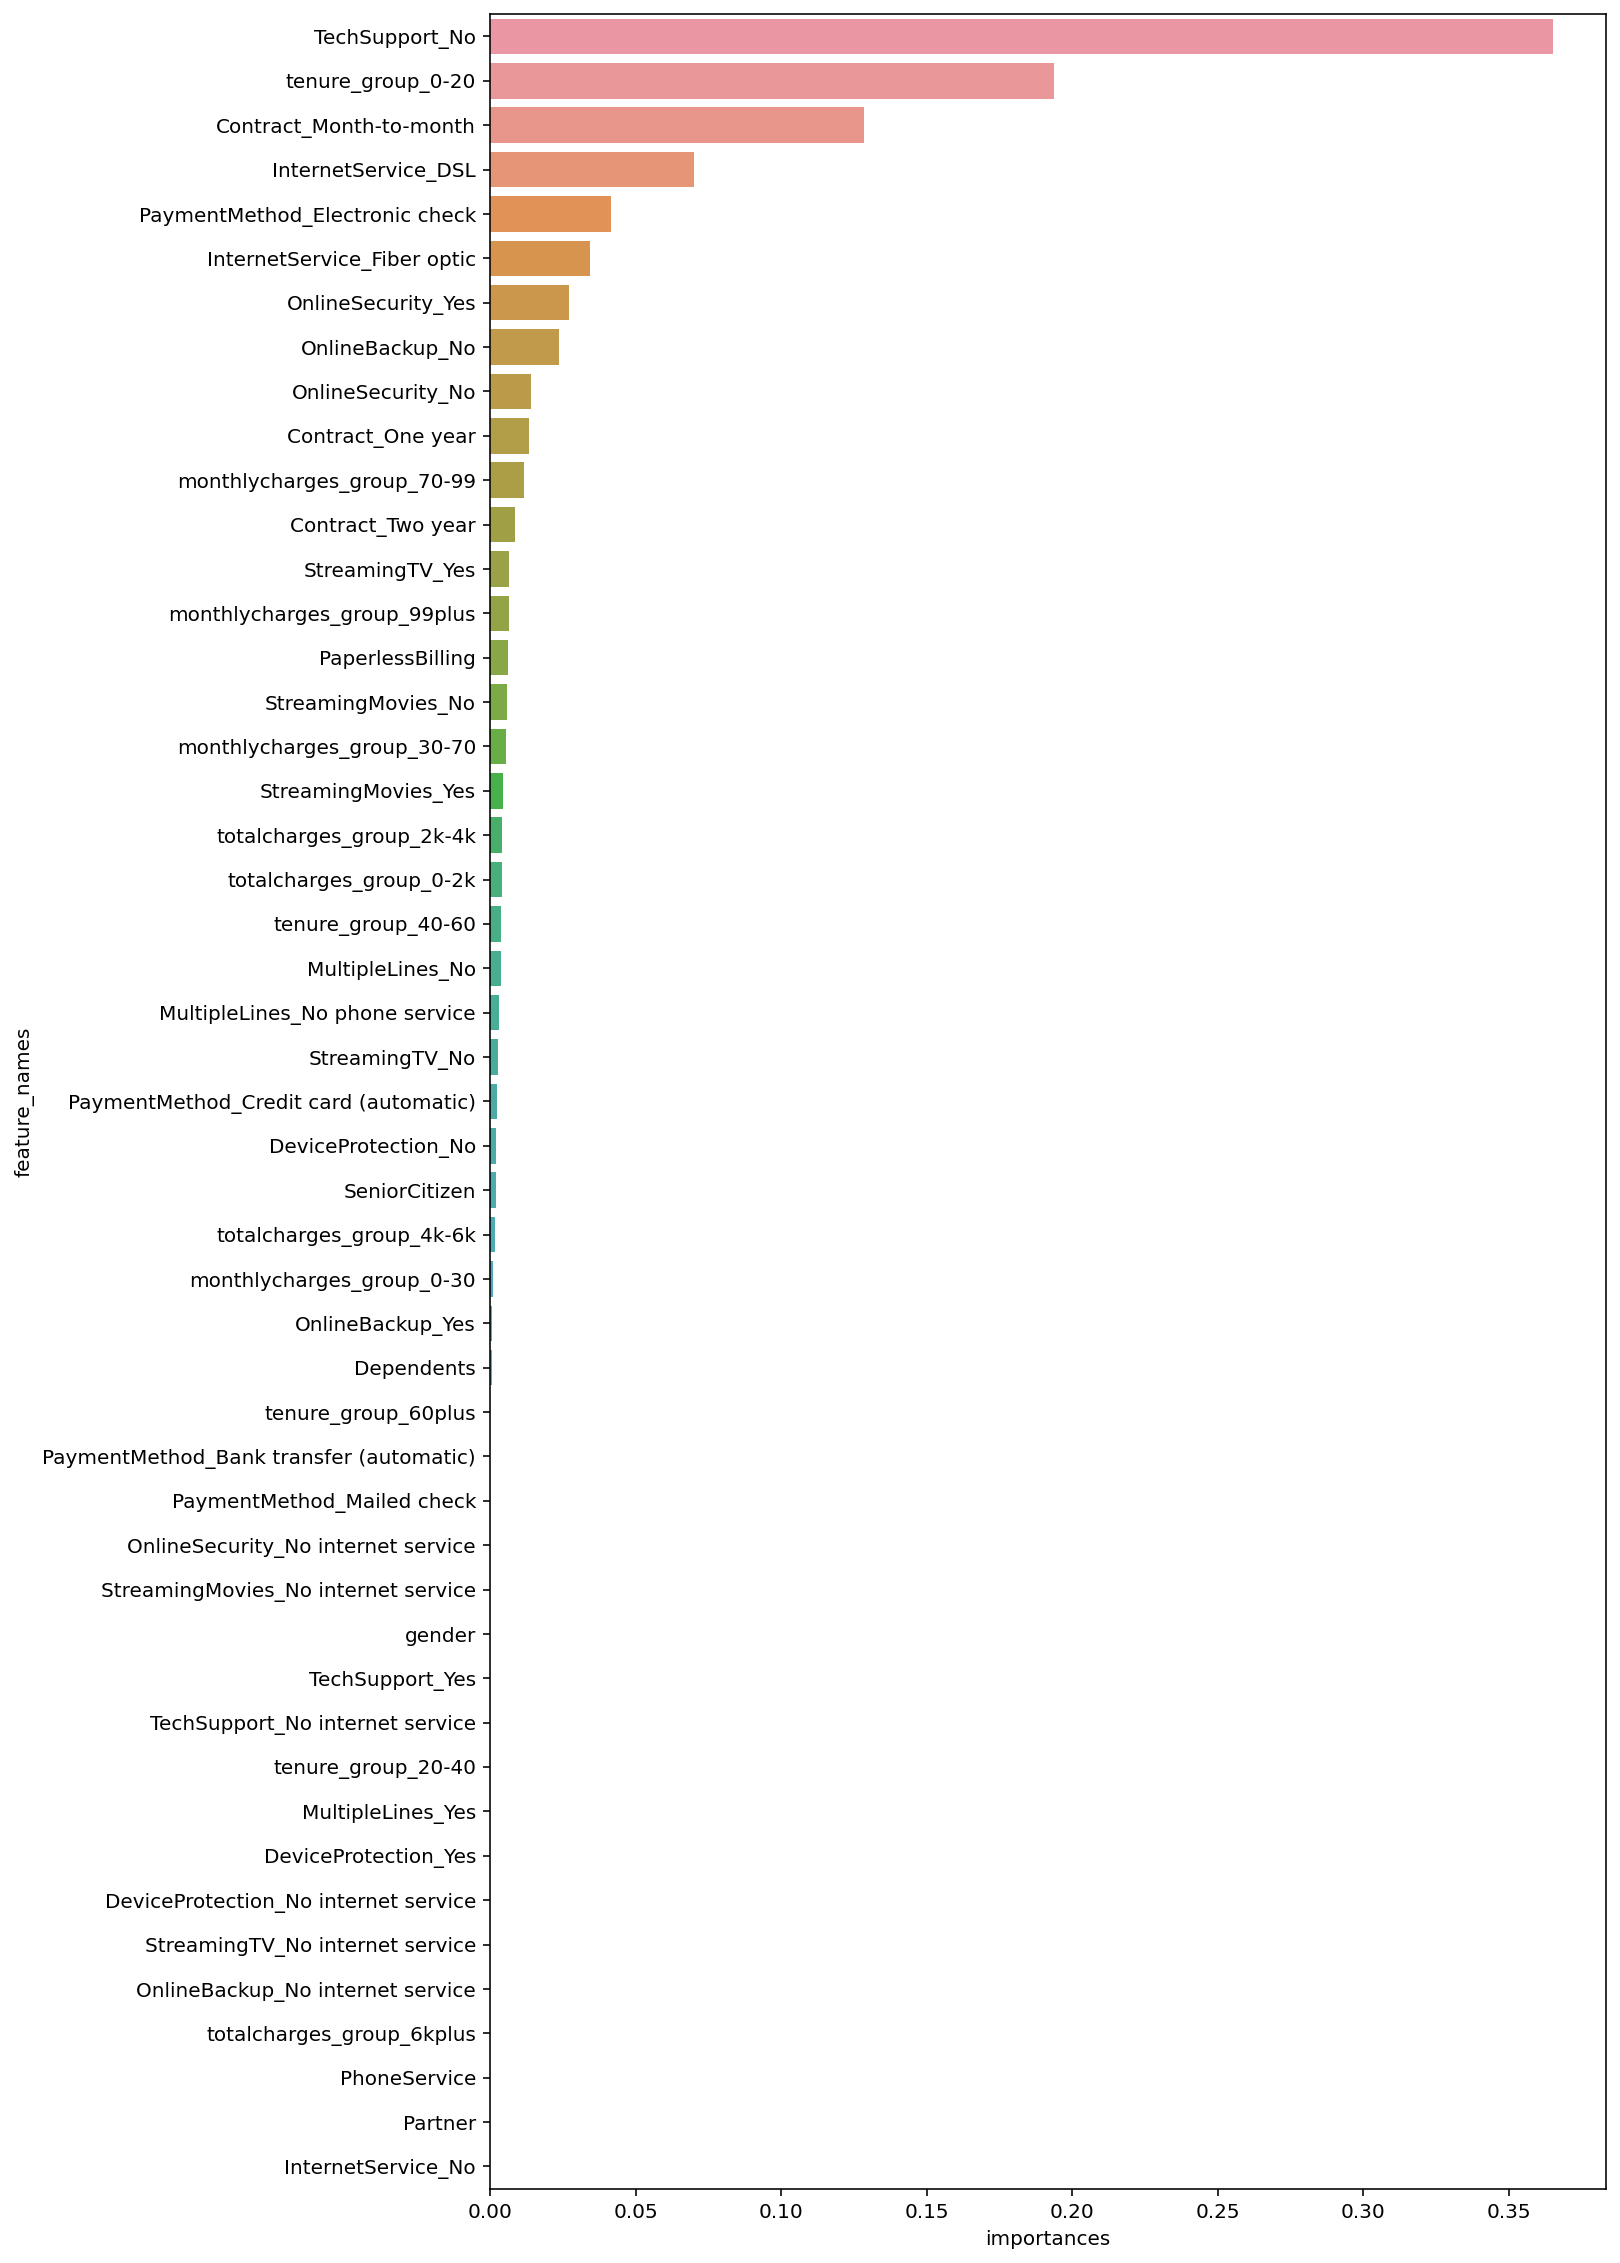

In [49]:
# 피처의 중요도 시각화 하기
plt.figure(figsize=(10, 20))
sns.barplot(data=importances, x="importances", y="feature_names")

### 점수 측정하기
#### Accuracy

In [50]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict)

0.8090844570617459

In [51]:
(y_test == y_predict).mean()

0.8090844570617459

#### F1 score
* precision 과 recall의 조화평균
* [정밀도와 재현율 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%A0%95%EB%B0%80%EB%8F%84%EC%99%80_%EC%9E%AC%ED%98%84%EC%9C%A8)

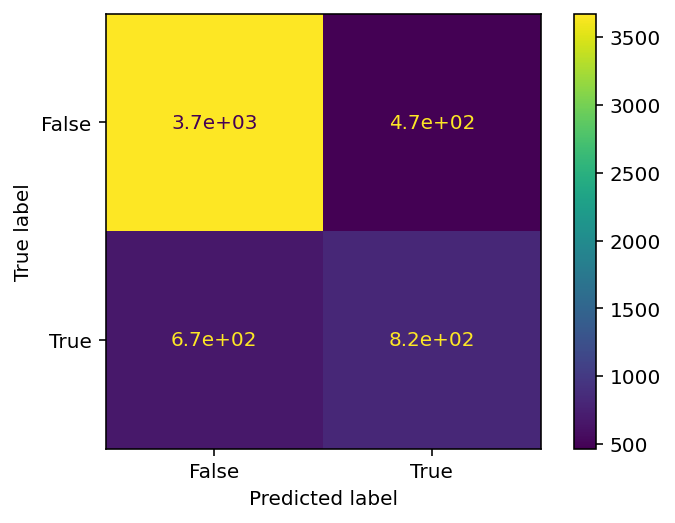

In [52]:
# plot_confusion_matrix 를 그립니다.
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_train, y_train)

In [53]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

       False       0.86      0.89      0.87      1036
        True       0.65      0.60      0.62       373

    accuracy                           0.81      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.81      0.81      1409

